# SciKit Transformations

This tutorial notebook demonstrates SciKit-Learn more SciKit-Learn transformations, in particular:

- Using {py:class}`sklearn.preprocessing.FunctionTransformer` to transform two columns into one
- Using {py:class}`sklearn.preprocessing.OneHotEncoder` to transform a categorical column into a dummy-coded column

It builds on the ideas in the [penguin regression notebook](Regressions.ipynb), and uses the same data.

## Setup

First, we are going to import our basic packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

And some SciKit-Learn code:

In [2]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

And initialize the RNG:

In [3]:
import seedbank
seedbank.initialize(20211102)

SeedSequence(
    entropy=20211102,
)

We're going to use the Penguins data:

In [4]:
penguins = pd.read_csv('../data/penguins.csv')

In [5]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Our goal is to predict penguin body mass. We're going to remove the data where we cannot predict that:

In [6]:
predictable = penguins[penguins.body_mass_g.notnull()]
predictable = predictable[predictable['sex'].notnull()]

And make a train-test split:

In [7]:
train, test = train_test_split(predictable, test_size=0.2)

What does the training data look like?

In [8]:
train.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
223,Gentoo,Biscoe,46.4,15.6,221.0,5000.0,male,2008
273,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,male,2009
145,Adelie,Dream,39.0,18.7,185.0,3650.0,male,2009
119,Adelie,Torgersen,41.1,18.6,189.0,3325.0,male,2009
16,Adelie,Torgersen,38.7,19.0,195.0,3450.0,female,2007


## Bill Ratio

First, I would like to demonstrate how to use {py:class}`sklearn.preprocessing.FunctionTransformer` to compute a feature from two variables: specifically, we are going to compute the *bill ratio* (bill length / bill depth) for each penguin.

In [9]:
def column_ratio(mat):
    """
    Compute the ratio of two columns.
    """
    rows, cols = mat.shape
    assert cols == 2  # if we don't have 2 columns, things are unexpected
    
    if hasattr(mat, 'iloc'):
        # Pandas object, use iloc
        res = mat.iloc[:, 0] / mat.iloc[:, 1]
        return res.to_frame()
    else:
        # probably a numpy array
        res = mat[:, 0] / mat[:, 1]
        return res.reshape((rows, 1))

Let's test this on our bill columns:

In [10]:
column_ratio(train[['bill_length_mm', 'bill_depth_mm']])

,0
223,2.974359
273,3.210191
145,2.085561
119,2.209677
16,2.036842
...,...
207,2.922078
124,2.213836
200,3.375940
204,3.131944


Now, let's wrap it up in a function transformer and a column transformer:

In [11]:
tf_br = FunctionTransformer(column_ratio)
tf_pipe = ColumnTransformer([
    ('bill_ratio', tf_br, ['bill_length_mm', 'bill_depth_mm'])
])

And apply this to our training data:

In [12]:
ratios = tf_pipe.fit_transform(train)
ratios[:5, :]  # first 5 rows

array([[2.97435897],
       [3.21019108],
       [2.0855615 ],
       [2.20967742],
       [2.03684211]])

That's how you can use SciKit-Learn pipelines to combine features!

## Dummy Coding

:::{index} encoding; dummy, encoding; one-hot
:::

Our species and gender are categorical variables.  For these we want to use dummy-coding or one-hot encoding; we specifically need the version that drops one variable, since we are doing a linear model.

We can do this with {py:class}`sklearn.preprocessing.OneHotEncoder`.  It takes an option to control dropping, and returns the encoded version of a variable.

Let's see it in action:

In [13]:
enc = OneHotEncoder(drop='first')
dc = enc.fit_transform(train[['species']])
dc[:5, :].toarray()

array([[0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

We can one-hot encode multiple categories at a single shot:

In [14]:
dc = enc.fit_transform(train[['species', 'sex']])
dc[:5, :].toarray()

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

We get 3 columns: 2 for the 3 levels of species, and 1 for the 2 levels of sex.

## Putting It Together

Let's now fit the model for [penguins with sexual dimorphism](penguin-dimorphism), along with bill ratio and the excluded pairwise interactions. We're going to do this by:

- Dummy-coding species and sex
- Taking the bill ratio
- Standardizing flipper length
- Computing all pairwise interaction terms with {py:class}`sklearn.preprocessing.PolynomialFeatures`
- Training a linear model, *without* intercepts (because the polynomial features adds a bias column)

In [15]:
lm_pipe = Pipeline([
    ('columns', ColumnTransformer([
        ('bill_ratio', FunctionTransformer(column_ratio), ['bill_length_mm', 'bill_depth_mm']),
        ('cats', OneHotEncoder(drop='first'), ['species', 'sex']),
        ('nums', StandardScaler(), ['flipper_length_mm']),
    ])),
    ('interact', PolynomialFeatures()),
    ('model', LinearRegression(fit_intercept=False)),
])

Now we will fit the model:

In [16]:
lm_pipe.fit(train, train['body_mass_g'])

Pipeline(steps=[('columns',
                 ColumnTransformer(transformers=[('bill_ratio',
                                                  FunctionTransformer(func=<function column_ratio at 0x7f4672198a60>),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm']),
                                                 ('cats',
                                                  OneHotEncoder(drop='first'),
                                                  ['species', 'sex']),
                                                 ('nums', StandardScaler(),
                                                  ['flipper_length_mm'])])),
                ('interact', PolynomialFeatures()),
                ('model', LinearRegression(fit_intercept=False))])

What coefficients did this learn?

In [17]:
lm_pipe.named_steps['model'].coef_

array([ 5.37764531e+03, -1.16456891e+03,  3.31159495e+01, -3.23365336e+01,
       -8.40322809e+01,  7.02871964e+02,  1.39456020e+02,  1.54343148e+02,
        4.53204622e+02,  3.89303486e+02, -2.26860691e+02,  3.31159495e+01,
        2.27373675e-13, -6.81412838e+02,  2.55991981e+02, -3.23365336e+01,
       -5.95673146e+02,  2.44013269e+02, -8.40322809e+01,  9.26757085e+01,
        3.09541362e+01])

Now we can predict:

In [18]:
preds = lm_pipe.predict(test.drop(columns=['body_mass_g']))

In [19]:
mean_squared_error(test['body_mass_g'], preds)

87506.93221715576

We don't really know how good that is without a reference point, but let's predict mass by prediction over our test data:

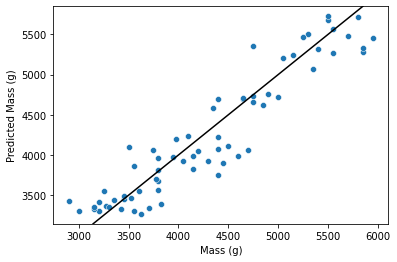

In [20]:
sns.scatterplot(x=test['body_mass_g'], y=preds)
plt.axline((4000, 4000), slope=1, color='black')
plt.xlabel('Mass (g)')
plt.ylabel('Predicted Mass (g)')
plt.show()

I'd say that doesn't look too bad!

## Regularization

Let's compare that model with a regularized one.

In [23]:
reg_pipe = Pipeline([
    ('columns', ColumnTransformer([
        ('bill_ratio', FunctionTransformer(column_ratio), ['bill_length_mm', 'bill_depth_mm']),
        ('cats', OneHotEncoder(drop='first'), ['species', 'sex']),
        ('nums', StandardScaler(), ['flipper_length_mm']),
    ])),
    ('interact', PolynomialFeatures()),
    ('model', ElasticNetCV(l1_ratio=np.linspace(0.1, 1, 5), fit_intercept=False)),
])

Fit to our training data:

In [24]:
reg_pipe.fit(train, train['body_mass_g'])

Pipeline(steps=[('columns',
                 ColumnTransformer(transformers=[('bill_ratio',
                                                  FunctionTransformer(func=<function column_ratio at 0x7f4672198a60>),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm']),
                                                 ('cats',
                                                  OneHotEncoder(drop='first'),
                                                  ['species', 'sex']),
                                                 ('nums', StandardScaler(),
                                                  ['flipper_length_mm'])])),
                ('interact', PolynomialFeatures()),
                ('model',
                 ElasticNetCV(fit_intercept=False,
                              l1_ratio=array([0.1  , 0.325, 0.55 , 0.775, 1.   ])))])

Let's get curious - what L1 ratio did we learn?

In [25]:
reg_pipe.named_steps['model'].l1_ratio_

1.0

And what $\alpha$ (regularization strength)?

In [26]:
reg_pipe.named_steps['model'].alpha_

30.840025137441792

Coefficients?

In [27]:
reg_pipe.named_steps['model'].coef_

array([ 940.27109261, 1213.59537801,   -0.        ,    0.        ,
          0.        ,    0.        ,  -21.53626477, -186.12301408,
         -0.        ,  228.91135821,   35.75589617,   -0.        ,
          0.        ,   -0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          6.06733598])

Now let's compute the prediction error:

In [28]:
reg_preds = reg_pipe.predict(test.drop(columns=['body_mass_g']))
mean_squared_error(test['body_mass_g'], reg_preds)

139309.94034484721

It's worse!  Not everything that is sometimes helpful is always helpful.

## Conclusion

The primary purpose of this notebook was to demonstrate use of more SciKit-Learn transformation capabilities.